Training data shape: (931559, 10, 16)
Validation data shape: (199621, 10, 16)
Test data shape: (199620, 10, 16)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,713 (483.25 KB)

 Trainable params: 123,713 (483.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
29108/29112 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 221.2137

29112/29112 ━━━━━━━━━━━━━━━━━━━━ 187s 6ms/step - loss: 221.1877 - val_loss: 5.0473
Epoch 2/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 4111s 141ms/step - loss: 7.1279 - val_loss: 13.4287
Epoch 12/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 163s 6ms/step - loss: 7.5968 - val_loss: 12.4242
Epoch 13/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 159s 5ms/step - loss: 7.2535 - val_loss: 20.8568
Epoch 14/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 172s 6ms/step - loss: 6.3086 - val_loss: 16.9093
Epoch 15/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 692s 24ms/step - loss: 5.8799 - val_loss: 24.3619
Epoch 16/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 653s 22ms/step - loss: 5.8277 - val_loss: 26.8941
Epoch 17/100
29112/29112 ━━━━━━━━━━━━━━━━━━━━ 181s 6ms/step - loss: 5.5906 - val_loss: 23.0642
Test Loss (MSE): 4.37746524810791


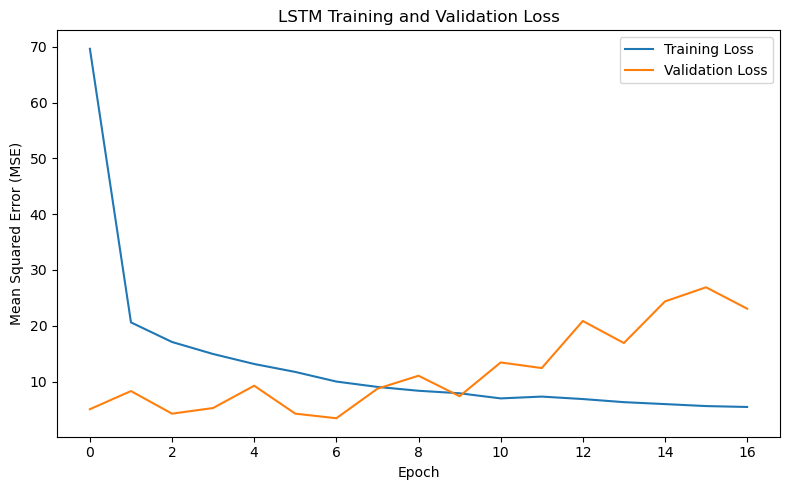

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


df = pd.read_csv("processed_data.csv")

# Separate features and target variable
target_col = "motor_temperature"
feature_cols = [col for col in df.columns if col != target_col]
X = df[feature_cols].values
y = df[target_col].values


# Create Time-Series Sequences
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Number of time steps per sample
window_size = 10  
X_seq, y_seq = create_sequences(X, y, window_size)



# Split Data Chronologically
n = len(X_seq)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train_seq = X_seq[:train_end]
y_train_seq = y_seq[:train_end]

X_val_seq = X_seq[train_end:val_end]
y_val_seq = y_seq[train_end:val_end]

X_test_seq = X_seq[val_end:]
y_test_seq = y_seq[val_end:]

print("Training data shape:", X_train_seq.shape)
print("Validation data shape:", X_val_seq.shape)
print("Test data shape:", X_test_seq.shape)


# LSTM model 

model = Sequential()

# First LSTM layer with 128 units
model.add(LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with 64 units
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))

# Adam optimizer and MSE loss function
model.compile(optimizer='adam', loss='mse')


model.summary()



# Stop training if validation loss doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model during training
checkpoint = ModelCheckpoint("best_lstm_model.h5", monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,            
    batch_size=32,         
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop, checkpoint],
    verbose=1
)


# Evaluate the Model on the Test Set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print("Test Loss (MSE):", test_loss)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.tight_layout()
plt.show()

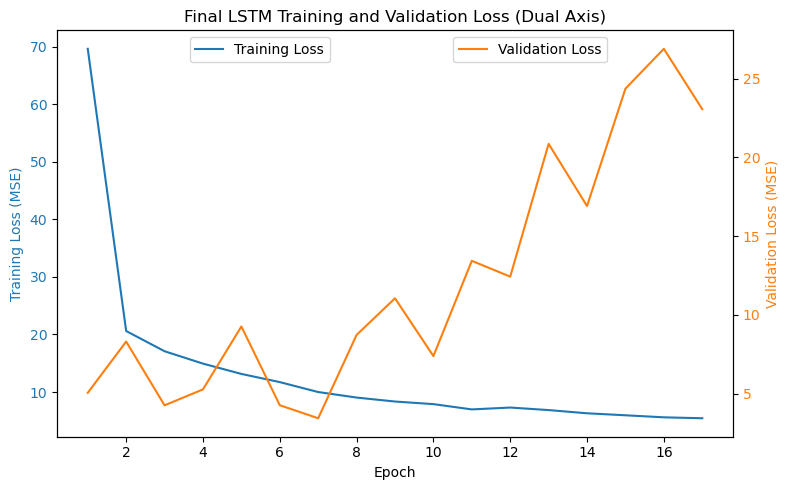

In [3]:
import matplotlib.pyplot as plt

def plot_dual_axis_loss(history):

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)

    fig, ax1 = plt.subplots(figsize=(8, 5))


    color1 = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss (MSE)', color=color1)
    ax1.plot(epochs, train_loss, label='Training Loss', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Validation Loss (MSE)', color=color2)
    ax2.plot(epochs, val_loss, label='Validation Loss', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax1.legend(loc='upper center', bbox_to_anchor=(0.3, 1.0))
    ax2.legend(loc='upper center', bbox_to_anchor=(0.7, 1.0))

    plt.title("Final LSTM Training and Validation Loss (Dual Axis)")
    plt.tight_layout()
    plt.show()

plot_dual_axis_loss(history)